# Model Parameterization and Evaluation

## Metabolic Model Inputs

### Packages

In [1]:
# General
import pandas as pd
import numpy as np
import pandas as pd
import os
DATA_DIR = "~/Desktop/code/data/"

# Pipeline
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

from sklearn.decomposition import PCA 
import umap
import hdbscan

from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Visualization
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

### Dataset

In [2]:
df = pd.read_csv(os.path.join(DATA_DIR, "model", "ml_input.csv"), low_memory=False)

filter = df["ec"].str.contains("-") # filter non-specific ec numbers, e.g., 1.1.1.-
df = df[~filter]

df = df[["taxon_id", "media_id", "ec"]].value_counts().reset_index()
df = df.pivot(index=["taxon_id", "media_id"], columns="ec", values="count")
df = df.fillna(0.0).reset_index()

# Filtering into training and test sets (database set vs. MAGs)
bins = df["media_id"].str.contains("unknown")
df_train = df[~bins]

# Create a mapping from media_id to a float and apply to dataframe
#media_id_mapping = {media_id: float(i) for i, media_id in enumerate(df_train['media_id'].unique())}
#df_train['media_id_float'] = df_train["media_id"].map(media_id_mapping)

print(len(df_train), "samples")
df_train.head()

8464 samples


ec,taxon_id,media_id,1.1.1.1,1.1.1.100,1.1.1.101,1.1.1.102,1.1.1.103,1.1.1.105,1.1.1.107,1.1.1.108,...,7.6.2.12,7.6.2.13,7.6.2.14,7.6.2.15,7.6.2.16,7.6.2.2,7.6.2.5,7.6.2.7,7.6.2.8,7.6.2.9
0,100.0,J346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100.0,J386,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100225.0,J233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1002526.0,J22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1004166.0,1a,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
len(df_train)

8464

## Model

### Testing parameters

In [4]:
# Split the datasets into training and test sets
TARGET = "taxon_id" # target label "media_id"
RANDOM_SEED = 47 # seed for random_state

# Model validation with only labeled samples from data.ipynb
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop(["taxon_id", "media_id"], axis=1),
    df_train[TARGET],
    test_size=0.2,
    random_state=RANDOM_SEED
)

In [5]:
X1 = pd.DataFrame(X_train)
X2 = pd.DataFrame(X_test)
y1 = pd.DataFrame(y_train)
y2 = pd.DataFrame(y_test)

X1["Set"] = "Train"
X2["Set"] = "Test"
y1["Set"] = "Train"
y2["Set"] = "Test"

x_frames = X1, X2
y_frames = y1, y2

X_split = pd.concat(x_frames)
y_split = pd.concat(y_frames)

X_split.to_csv("~/Desktop/X_split.csv")
y_split.to_csv("~/Desktop/y_split.csv")

In [4]:
# Test a range of parameters for dimensionality reduction
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, silhouette_score

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(
        n_components=150,
        random_state= RANDOM_SEED
        )),  
    ('umap', umap.UMAP(  
        metric="euclidean",
        n_epochs=500,
        random_state=RANDOM_SEED,
        n_jobs=1,
        ))
])

# Define parameter grid with correct step names
param_distributions = {
    'umap__n_components': range(2,50),
    'umap__n_neighbors': range(20,100), 
    'umap__min_dist': range(0,1)
}

# Custom scorer function
def umap_silhouette(X, y):
    embedding = X  # X here is already the transformed data by UMAP
    return silhouette_score(embedding, y)

# Wrap the custom scorer
scorer = make_scorer(umap_silhouette, greater_is_better=True)

# Initialize RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    scoring=scorer
)

# Fit the search to your data
#search.fit(X_train, y_train)
#best_params = search.best_params_
#best_model = search.best_estimator_

#print("Best Parameters:", best_params) 

### Pipeline

In [5]:
# sklearn pipeline helps prevent data leakage; incorporate best_params here
pipeline = Pipeline([
    ('scaler', StandardScaler()),    
    ('pca', PCA(
        n_components=150,
        random_state= RANDOM_SEED
        )), 
    ('umap', umap.UMAP(             
        metric="euclidean",
        n_epochs=500, 
        random_state=RANDOM_SEED,
        n_jobs=1,
        n_components=40, 
        n_neighbors=62, 
        min_dist=0
        )) 
])

# Fit and transform
X_train_transformed = pipeline.fit_transform(X_train) # fit pipeline and transform training data
X_test_transformed = pipeline.transform(X_test) # transform test data

### Optimizing n_clusters

In [6]:
# Silhouette coefficient method
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Test a range of clusters for their silhouette coefficients
#clusters = []
#for n_cluster in range(100, 300):
#    kmeans = KMeans(n_clusters=n_cluster).fit(X_train_transformed)
#    label = kmeans.labels_
#    sil_coeff = silhouette_score(X_train_transformed, label, metric='euclidean')
#    clusters.append({'n_clusters': n_cluster, 'coefficient': sil_coeff})

# Select the maximum coefficient
#clusters = pd.DataFrame(clusters)
#c = clusters.iloc[clusters["coefficient"].argmax()]["n_clusters"]
#s = clusters["coefficient"].max()
#n = int(c)+1

#print("{} clusters returns a maximum Silhouette Coefficient of {}".format(n, s))

In [7]:
# Cluster using maximum coefficient's n_clusters
clusterer = KMeans(n_clusters=182, random_state=RANDOM_SEED)
training_clusters = clusterer.fit_predict(X_train_transformed)
test_clusters = clusterer.predict(X_test_transformed)

### Metrics

In [8]:
# Initial dimensionality reduction performance (PCA)
pca = pipeline.named_steps['pca']
explained_variance = pca.explained_variance_ratio_
print(f"Total PCA explained variance: {explained_variance.sum()}")

# Further dimensionality reduction and clustering performance
silhouette_avg = silhouette_score(X_train_transformed, training_clusters)
print(clusterer.labels_.max()+1, "KMeans training clusters")
print(f"Average Silhouette Score on KMeans clusters: {silhouette_avg}")
    # Silhouette score <=0.25 implies poor clustering, 0.25<x<=0.50 is fair, <50 is good

#173, 0.73951; 178, 0.74609; 180, 0.74886; 185, 0.74425; 187, 0.74365; ... 223, 0.73052

Total PCA explained variance: 0.8869085094399837
182 KMeans training clusters
Average Silhouette Score on KMeans clusters: 0.7505251169204712


In [9]:
# Compare to hdbscan clustering 

# Apply HDBSCAN clustering on the transformed training data
hclusterer = hdbscan.HDBSCAN(
    min_samples=5, 
    min_cluster_size=15, 
    #gen_min_span_tree=True, 
    prediction_data=True # cluster_selection_method="leaf", for more fine-grained clustering
)
htraining_clusters = hclusterer.fit_predict(X_train_transformed)

# Clustering performance (UMAP and hdbscan)
hsilhouette_avg = silhouette_score(X_train_transformed, htraining_clusters)
print(hclusterer.labels_.max(), "hdbscan training clusters")
print(f"Silhouette Score on hdbscan clusters: {hsilhouette_avg}")

# Convert to numpy array for hdbscan and predict clustering
#test_points = test_df[["Component 1", "Component 2"]].to_numpy()
#test_labels, strengths = hdbscan.approximate_predict(clusterer, test_points)

# Optional constraints
#filtered = train_df[train_df['Cluster'] >= 0]
#test_labels = clusterer.fit_predict(X_test_transformed)

147 hdbscan training clusters
Silhouette Score on hdbscan clusters: 0.5884481072425842


## Classifier

In [10]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

In [11]:
y2_train = training_clusters
y2_test = test_clusters

### Random Forest

In [12]:
rfc = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=RANDOM_SEED
)

rfc.fit(X_train_transformed, y2_train)
print(rfc.predict(X_test_transformed))

[ 14  61 104 ... 130   6  76]


In [13]:
report = classification_report(
    y_true=y2_test,
    y_pred=rfc.predict(X_test_transformed),
    zero_division=0.0 # Default: set to "warn", or float {0.0, 1.0}
)

roc_score = metrics.roc_auc_score(
    y_true=y2_test,
    y_score=rfc.predict_proba(X_test_transformed),
    labels=np.unique(y2_train),
    average="weighted",
    multi_class="ovo"
)

print(report)
print("RF ROC AUC score:", roc_score)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      0.90      0.95        20
           2       1.00      1.00      1.00        16
           3       1.00      0.98      0.99        53
           4       1.00      1.00      1.00        42
           5       1.00      0.88      0.93         8
           6       0.94      1.00      0.97        16
           7       1.00      1.00      1.00        43
           8       1.00      1.00      1.00        50
           9       1.00      0.67      0.80         6
          10       1.00      0.95      0.98        21
          11       1.00      1.00      1.00        18
          12       1.00      1.00      1.00        38
          13       1.00      1.00      1.00        26
          14       0.91      1.00      0.95        21
          15       1.00      1.00      1.00         5
          16       0.95      1.00      0.98        21
          17       1.00    

### Nearest Neighbors

In [14]:
knc= KNeighborsClassifier(n_neighbors=1)
knc.fit(X_train_transformed, training_clusters)

X_test_reindexed = list(X_test_transformed) # is this mapping accurate?

distances, indices = knc.kneighbors(X_test_reindexed)

print(knc.predict(X_test_transformed))
indices

[ 14  61 104 ... 130   6  76]


array([[ 569],
       [6206],
       [6764],
       ...,
       [1757],
       [5628],
       [4254]], dtype=int64)

In [15]:
report = classification_report(
    y_true=y2_test,
    y_pred=knc.predict(X_test_transformed),
    zero_division=0.0 # Default: set to "warn", or float {0.0, 1.0}
)

roc_score = metrics.roc_auc_score(
    y_true=y2_test,
    y_score=knc.predict_proba(X_test_transformed),
    labels=np.unique(y2_train),
    average="weighted",
    multi_class="ovo"
)

print(report)
print("KNN ROC AUC score:", roc_score)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       0.90      0.95      0.93        20
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        53
           4       1.00      1.00      1.00        42
           5       1.00      0.88      0.93         8
           6       1.00      1.00      1.00        16
           7       1.00      1.00      1.00        43
           8       1.00      1.00      1.00        50
           9       1.00      0.83      0.91         6
          10       0.94      0.81      0.87        21
          11       1.00      1.00      1.00        18
          12       1.00      1.00      1.00        38
          13       1.00      1.00      1.00        26
          14       1.00      1.00      1.00        21
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00        21
          17       1.00    

## Dataframes

In [16]:
# Training data
train_df = pd.DataFrame(X_train_transformed, columns=[f"Component {i+1}" for i in range(X_train_transformed.shape[1])])
train_df['Set'] = 'Training'
y_train_labels = list(y_train)
train_df['Target'] = y_train_labels
train_df['KMeans Cluster'] = training_clusters

# Media cluster labels
media_clusters = pd.read_csv(os.path.join(DATA_DIR, "model", "media-clusters.csv"))
media_clusters = media_clusters[["media_id", "Media Cluster"]]
media_clusters = media_clusters.rename(columns={"media_id": "Target"})
target_label_mapping = dict(zip(media_clusters['Target'], media_clusters['Media Cluster']))
train_df['Media Cluster'] = train_df['Target'].map(target_label_mapping)

train_df.to_csv(os.path.join(DATA_DIR, "model", "param-train-output.csv"), index=False)

print(len(train_df))
train_df.head()

6771


,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,...,Component 35,Component 36,Component 37,Component 38,Component 39,Component 40,Set,Target,KMeans Cluster,Media Cluster
0,9.004272,3.287887,4.192002,4.919508,2.469864,6.084774,2.985002,7.050509,5.174880,4.042890,...,4.902360,4.721021,4.917609,5.054856,2.191289,3.794339,Training,535a,155,15.0
1,8.953607,2.713383,3.910982,5.377469,3.294208,5.038115,2.905794,6.771725,4.393070,4.581178,...,5.091610,3.499133,6.066790,4.524912,1.808338,3.722527,Training,J569,48,19.0
2,8.881487,3.994849,5.083898,4.709289,2.508067,6.509837,5.318863,3.806595,5.740467,5.450956,...,4.145268,5.047581,0.187894,10.940918,11.037705,8.796391,Training,J22,69,9.0
3,8.991222,4.912221,5.206003,3.655744,2.022998,7.516963,5.696278,2.571991,2.162688,18.361250,...,5.534949,4.466784,5.424626,4.071472,4.678117,6.487770,Training,110a,161,1.0
4,9.022937,5.124177,4.946032,4.268633,2.517056,5.764732,5.533686,4.451222,5.860332,4.754421,...,4.082406,6.066327,2.686215,8.400088,8.523630,5.914005,Training,J386,126,3.0


In [17]:
# Test data
test_df = pd.DataFrame(X_test_transformed, columns=[f"Component {i+1}" for i in range(X_test_transformed.shape[1])])
test_df['Set'] = 'Test'
y_test_labels = list(y_test)
test_df['Target'] = y_test_labels
test_df['KMeans Cluster'] = test_clusters

# Add classifier labels 
test_df["KNN Classify"] = knc.predict(X_test_transformed)
test_df["RF Classify"] = rfc.predict(X_test_transformed)

test_df.to_csv(os.path.join(DATA_DIR, "model", "param-test-output.csv"), index=False)

print(len(test_df))
test_df.head()

1693


,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,...,Component 36,Component 37,Component 38,Component 39,Component 40,Set,Target,KMeans Cluster,KNN Classify,RF Classify
0,8.351797,0.852247,4.200400,6.035208,5.658079,1.501098,4.478942,4.541025,-9.537567,-1.587987,...,4.002735,6.031918,4.319628,4.336377,5.884031,Test,J52,14,14,14
1,9.116566,3.335997,4.257720,4.723074,1.800073,7.005590,2.287787,8.147466,5.861635,3.500243,...,5.065358,4.667674,4.838738,1.632623,3.479139,Test,514c,61,61,61
2,9.111436,5.017015,5.145980,4.088708,2.298879,5.916233,5.694280,4.121254,6.122138,4.915298,...,6.641979,3.015048,8.993248,9.296829,5.903651,Test,600a,104,104,104
3,8.858748,3.893615,5.079161,4.706461,2.423123,6.620136,5.278337,3.814528,5.826170,5.487682,...,5.022187,0.123625,11.073009,11.029669,8.800240,Test,J40,179,179,179
4,9.079756,5.326394,5.037623,3.765283,2.536642,5.857183,5.595547,3.995820,6.196768,4.771795,...,6.658832,2.868980,8.507398,9.120639,6.301445,Test,1a,144,144,144


In [18]:
# Add nearest neighbor indices to the test dataframe
knn_df = test_df.copy()
knn_df = knn_df.rename(columns={"KMeans Cluster": "Test Cluster"})
neighbors = pd.DataFrame(indices) # Indices of nearest neighbors from the training set
knn_df['indices'] = neighbors[neighbors.columns[0:]].apply(lambda x: ';'.join(x.dropna().astype(str)), axis=1)
knn_df["indices"] = knn_df["indices"].str.split(';')
knn_df = knn_df.explode("indices")

# Add original indices as a column for the train dataframe
    # Index maps to original dataframe before train_test_split!
    # Randomizes => inaccurate nearest neighbor mapping based on indices (fine if X_test and X_train are defined as in 05-Model-Test)
train_index = train_df.copy()
train_index = train_index.rename(columns={"KMeans Cluster": "Train Cluster"})
y_train_labels = pd.DataFrame(y_train).reset_index() # reset of index, TODO: ensure this is correct mapping!
train_index["indices"] = y_train_labels.index 
train_index["indices"] = train_index["indices"].astype(str)

# Merge to label nearest neighbors
left = knn_df.copy()
right = train_index[["indices", "Target", "Media Cluster"]] #"taxon_id", 
right = right.rename(columns={"Target": "neighbor_media_id", "Train Cluster": "neighbor_cluster", "Media Cluster": "neighbor_media_cluster"})
merged = pd.merge(left, right, on="indices", how="left")

merged.to_csv(os.path.join(DATA_DIR, "model", "param-model-output.csv"), index=False)
merged

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,...,Component 39,Component 40,Set,Target,Test Cluster,KNN Classify,RF Classify,indices,neighbor_media_id,neighbor_media_cluster
0,8.351797,0.852247,4.200400,6.035208,5.658079,1.501098,4.478942,4.541025,-9.537567,-1.587987,...,4.336377,5.884031,Test,J52,14,14,14,569,J346,6.0
1,9.116566,3.335997,4.257720,4.723074,1.800073,7.005590,2.287787,8.147466,5.861635,3.500243,...,1.632623,3.479139,Test,514c,61,61,61,6206,J118,3.0
2,9.111436,5.017015,5.145980,4.088708,2.298879,5.916233,5.694280,4.121254,6.122138,4.915298,...,9.296829,5.903651,Test,600a,104,104,104,6764,J900,6.0
3,8.858748,3.893615,5.079161,4.706461,2.423123,6.620136,5.278337,3.814528,5.826170,5.487682,...,11.029669,8.800240,Test,J40,179,179,179,3090,J492,8.0
4,9.079756,5.326394,5.037623,3.765283,2.536642,5.857183,5.595547,3.995820,6.196768,4.771795,...,9.120639,6.301445,Test,1a,144,144,144,3181,J22,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1688,9.010366,3.495401,4.296191,4.768808,2.219537,6.431754,2.903861,7.134174,5.582446,3.923995,...,2.414466,3.649542,Test,J42,98,98,98,6083,J43,19.0
1689,8.734777,3.567869,5.073127,4.621852,2.210312,6.963587,5.138412,3.732153,6.045642,5.507172,...,10.935652,8.802583,Test,J124,172,172,172,5675,J436,NaN
1690,9.207585,5.184787,5.173047,3.904411,2.415402,5.825633,5.749841,3.939510,6.209697,4.803974,...,9.339425,6.032287,Test,J27,130,130,130,1757,514b,16.0
1691,8.943792,4.909190,5.250043,3.597408,1.941876,7.594574,5.773794,2.467060,2.043102,18.588192,...,4.670094,6.515646,Test,J14,6,6,6,5628,1203a,3.0


## Feature Importance

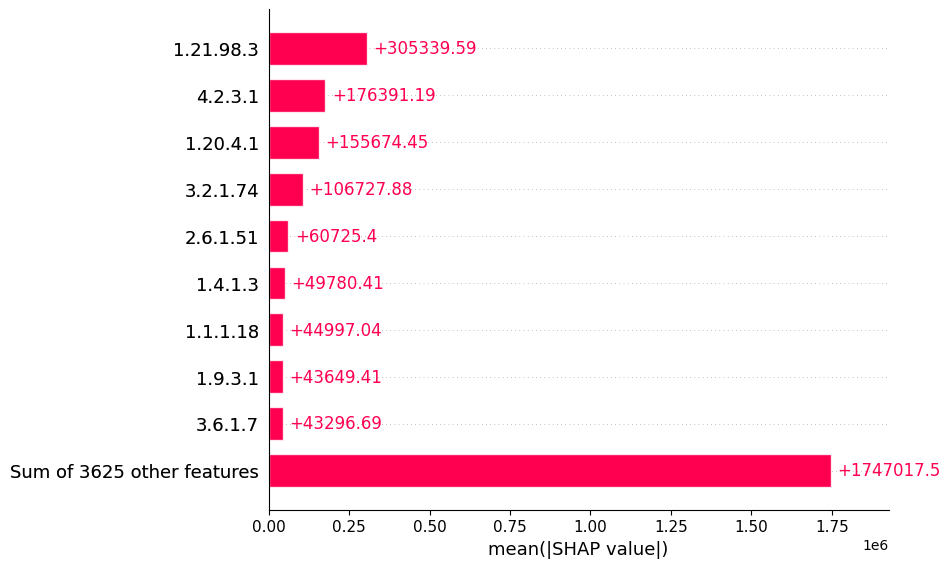

In [19]:
import xgboost
import shap

XG_train = df_train.drop(["taxon_id", "media_id"], axis=1)
yG_train = df_train["taxon_id"]

df_test = df[bins]
XG_test = df_test.drop(["taxon_id", "media_id"], axis=1)
yG_test = df_test["taxon_id"]

# train an XGBoost model
model = xgboost.XGBRegressor().fit(XG_train, yG_train)

# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(XG_test)

shap.plots.initjs()
#shap.plots.beeswarm(shap_values, max_display=11)
shap.plots.bar(shap_values, max_display=10)

[Text(0, 0, '   +305339.59'),
 Text(0, 0, '   +176391.19'),
 Text(0, 0, '   +155674.45'),
 Text(0, 0, '   +106727.88'),
 Text(0, 0, '   +60725.4'),
 Text(0, 0, '   +49780.04'),
 Text(0, 0, '   +44997.04'),
 Text(0, 0, '   +43649.41'),
 Text(0, 0, '   +43296.69'),
 Text(0, 0, '   +1747017.5')]

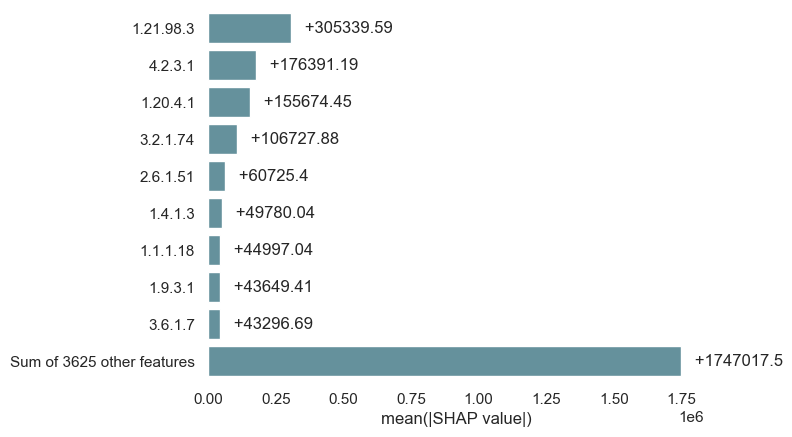

In [20]:
dict = {
    "features": ["1.21.98.3","4.2.3.1", "1.20.4.1", "3.2.1.74", "2.6.1.51", "1.4.1.3", "1.1.1.18", "1.9.3.1", "3.6.1.7", "Sum of 3625 other features"], #"4.1.1.17", 
    "importance": [305339.59, 176391.19, 155674.45, 106727.88, 60725.4, 49780.04, 44997.04, 43649.41, 43296.69, 1747017.5] #38625, 1708392.5
}

df = pd.DataFrame(dict)

df["labels"] = df["importance"].astype(str)
df["labels"] = "   +" + df["labels"]

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")
f, ax = plt.subplots()

sns.barplot(x="importance", y="features", data=df, color="#5c96a5")

ax.set(ylabel="", xlabel="mean(|SHAP value|)")
sns.despine(left=True, bottom=True)
ax.bar_label(ax.containers[0], labels=df["labels"])

# Media Model

In [ ]:
#TODO: copy from test.ipynb